# Exploration
This notebook conducts data exploration of the KM3NeT dataset. The following aspects of the dataset are explored:

- DONE descriptive statistics
- DONE NAN/NULL check
- DONE correlations
- TODO distributions of individual features
- TODO interesting plots (still thinking about this...)
- TODO timeseries specific visualizations
- TODO 3 dimensional data visualizations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

In [3]:
data = pd.read_csv("../data/processed/data.csv")

# Descriptive statistics
We start nice and simple with descriptive statistics of the entire dataset.

In [6]:
data.describe()

,pos_x,pos_y,pos_z,time,label,event_id,timeslice
count,4.582022e+07,4.582022e+07,4.582022e+07,4.582022e+07,4.582022e+07,489906.000000,4.582022e+07
mean,1.168440e-02,-1.597919e-02,1.171977e+02,5.005158e+07,1.069192e-02,2862.004542,3.336272e+03
std,5.125232e+01,6.222670e+01,4.865413e+01,2.891125e+07,1.028475e-01,1667.611022,1.927417e+03
min,-9.462700e+01,-1.156000e+02,3.770000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,-4.501800e+01,-5.792500e+01,7.404100e+01,2.500466e+07,0.000000e+00,1392.250000,1.666000e+03
50%,1.309000e+00,-4.184000e+00,1.217000e+02,5.004292e+07,0.000000e+00,2887.000000,3.336000e+03
75%,4.045200e+01,4.854100e+01,1.602410e+02,7.509229e+07,0.000000e+00,4304.750000,5.006000e+03
max,9.624300e+01,1.050240e+02,1.966110e+02,1.015914e+08,1.000000e+00,5734.000000,6.772000e+03


# NAN/NULL check
Background noise do not have an `event_id` and are represented as `nan` in the dataset.

In [4]:
data.isna().any()

pos_x        False
pos_y        False
pos_z        False
time         False
label        False
event_id      True
timeslice    False
dtype: bool

# Correlations
Check the correlations between the features. The standard "Pearson" correlation is used.

- No significant correlations are observed between pos_x,y,z and time. This already tells us that standard ML models will not work on the dataset, we need deep learning models to extract information.

In [7]:
corr = data.corr()
corr.style.background_gradient().set_precision(2)

,pos_x,pos_y,pos_z,time,label,event_id,timeslice
pos_x,1.00,-0.01,-0.00,-0.00,0.00,-0.02,-0.00
pos_y,-0.01,1.00,0.00,0.00,-0.00,0.00,0.00
pos_z,-0.00,0.00,1.00,-0.00,0.00,-0.01,-0.00
time,-0.00,0.00,-0.00,1.00,-0.00,-0.01,1.00
label,0.00,-0.00,0.00,-0.00,1.00,nan,-0.00
event_id,-0.02,0.00,-0.01,-0.01,nan,1.00,-0.01
timeslice,-0.00,0.00,-0.00,1.00,-0.00,-0.01,1.00


# Distributions
Now we consider the distributions of individual  features. The only plot we can create using the entire dataset is that of the `label` column. For the rest, we use select timeslices.

## label
Looking at the histogram of label we can see a huge class imbalance between events and noise data. To be precise, we only have 489906 events vs. 45330310 noise datapoints. An effective stratergy to handle class imbalance will need to be deviced during training.

In [32]:
data.groupby('label').count()

,pos_x,pos_y,pos_z,time,event_id,timeslice
label,,,,,,
0,45330310,45330310,45330310,45330310,0,45330310
1,489906,489906,489906,489906,489906,489906


In [91]:
labels, counts = np.unique(data.label, return_counts=True)

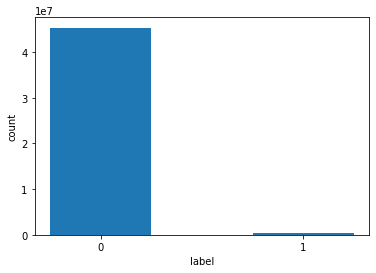

In [96]:
plt.bar(labels, counts, width=0.5, align='center')
plt.gca().set_xticks(labels)
plt.xlabel('label')
plt.ylabel('count')
plt.savefig('../assets/dist-label.png', dpi=200)

## Identifying interesting timeslices
We need to find some interesting timeslices to conduct further visualizations. First off, let's sort the dataset based on the rows in each timeslice in order to identify the largest/smallest timeslices.

In [4]:
timeslice_count = data.groupby('timeslice', as_index=True).count()
timeslice_count

,pos_x,pos_y,pos_z,time,label,event_id
timeslice,,,,,,
0,12454,12454,12454,12454,12454,0
1,6916,6916,6916,6916,6916,188
2,6805,6805,6805,6805,6805,2
3,6748,6748,6748,6748,6748,0
4,6697,6697,6697,6697,6697,0
...,...,...,...,...,...,...
6765,1,1,1,1,1,0
6766,1,1,1,1,1,0
6767,1,1,1,1,1,0


In [5]:
# count of timeslices with no events, just noise
timeslice_count[timeslice_count["event_id"] == 0].shape

(2783, 6)

Let's pick some interesting time slices:
1. time slices with the hits > 1500
1. time slices with hits < 500 
1. time slices with hits < 100
1. time slices with hits < 10

In [6]:
# 1.
timeslice_1500_ids = timeslice_count.sort_values(by='event_id',
    ascending=False).head().index
timeslice_1500_ids

Int64Index([615, 1637, 5866, 5857, 1232], dtype='int64', name='timeslice')

In [10]:
# 2.
timeslice_500_ids = timeslice_count[
    timeslice_count['event_id'] < 500].sort_values(by='event_id',
    ascending=False).head().index
timeslice_500_ids

Int64Index([4104, 1618, 1441, 5795, 6134], dtype='int64')

In [8]:
# 3.
timeslice_100_ids = timeslice_count[
    timeslice_count['event_id'] < 100].sort_values(by='event_id',
    ascending=False).head().index
timeslice_100_ids

Int64Index([1800, 2040, 1995, 789, 741], dtype='int64')

In [9]:
# 4.
timeslice_10_ids = timeslice_count[
    timeslice_count['event_id'] < 10].sort_values(by='event_id',
    ascending=False).head().index
timeslice_10_ids

Int64Index([3650, 5117, 6464, 5853, 702], dtype='int64')

50% of `timeslice_count` is randomly sampled and plotted (several times), we note that most of the timeslices have very few hits whilst very few timeslices have a lot of hits.

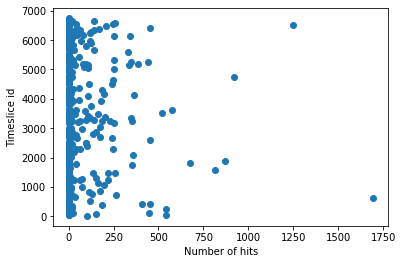

In [97]:
df = timeslice_count.sample(frac=0.05)
plt.scatter(df['event_id'], df['timeslice'])
plt.ylabel('Timeslice id')
plt.xlabel('Number of hits')
plt.savefig('../assets/dist-hits-per-timeslice.png', dpi=200)

## Timeslices with high hits
Exploring the timeslices with the highest count of hits. First we look at the timeslice with the most number of hits.

In [126]:
timeslice_largest = data[data['timeslice'] == timeslice_1500_ids[0]]

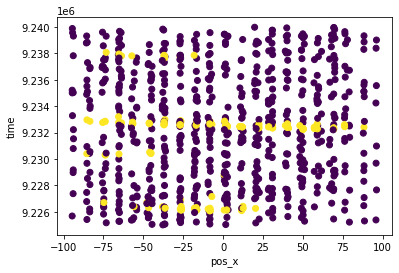

In [139]:
df = timeslice_largest.sample(frac=0.1)
plt.scatter(df['pos_x'], df['time'], c=df['label'])
plt.ylabel('time')
plt.xlabel('pos_x')
plt.savefig('../assets/dist-timeslice-largest-posx-time.png', dpi=200)

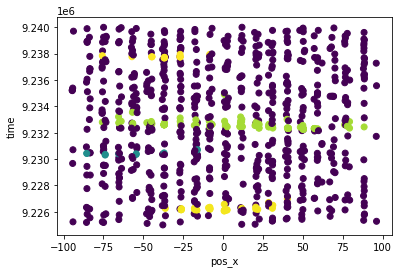

In [148]:
df = timeslice_largest.sample(frac=0.1)
# change the value here so that we can see can see the noise in the plot
df['event_id'] = df['event_id'].fillna(value=0)
plt.scatter(df['pos_x'], df['time'], c=df['event_id'])
plt.ylabel('time')
plt.xlabel('pos_x')
plt.savefig('../assets/dist-timeslice-largest-posx-time-eventid.png', dpi=200)

Next, the top 5 timeslices with.

In [121]:
timeslice_1500 = data[data['timeslice'].isin(timeslice_1500_ids)]
timeslice_1500

,pos_x,pos_y,pos_z,time,label,event_id,timeslice
4227660,48.363,-24.102,83.611,9225002.0,0,NaN,615
4227661,-37.784,30.774,94.341,9225007.0,0,NaN,615
4227662,-75.557,-6.893,56.111,9225008.0,0,NaN,615
4227663,-27.018,-60.655,150.731,9225013.0,0,NaN,615
4227664,76.914,-77.120,150.789,9225014.0,0,NaN,615
...,...,...,...,...,...,...,...
40276655,-36.243,101.898,187.211,88004990.0,0,NaN,5866
40276656,-44.781,-22.180,150.731,88004991.0,0,NaN,5866
40276657,50.125,12.122,168.831,88004995.0,0,NaN,5866
40276658,88.450,12.581,74.041,88004996.0,0,NaN,5866


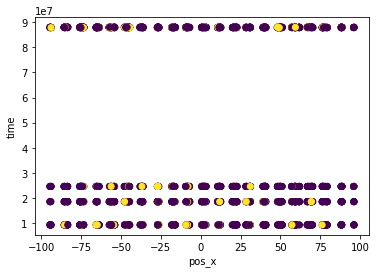

In [141]:
df = timeslice_1500.sample(frac=0.1)
plt.scatter(df['pos_x'], df['time'], c=df['label'])
plt.ylabel('time')
plt.xlabel('pos_x')
plt.savefig('../assets/dist-timeslice-1500-posx-time.png', dpi=200)

Text(0.5, 0, 'pos_x')

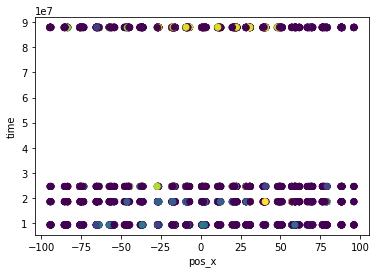

In [149]:
# NOTE: did not save this one, not that useful
df = timeslice_1500.sample(frac=0.1)
# change the value here so that we can see can see the noise in the plot
df['event_id'] = df['event_id'].fillna(value=0)
plt.scatter(df['pos_x'], df['time'], c=df['event_id'])
plt.ylabel('time')
plt.xlabel('pos_x')
# plt.savefig('../assets/dist-timeslice-largest-posx-time-eventid.png', dpi=200)

## Timeslices with low hits
Exploring the timeslices with the lowest count of hits.

In [157]:
timeslice_smallest = data[data['timeslice'] == timeslice_10_ids[0]]

In [165]:
df = timeslice_smallest.sample(frac=0.1)
df[df['label'] == 1]

,pos_x,pos_y,pos_z,time,label,event_id,timeslice
25060248,77.988,-40.148,55.941,54752308.0,1,4324.0,3650
25060190,88.381,-60.150,47.131,54752194.0,1,4324.0,3650


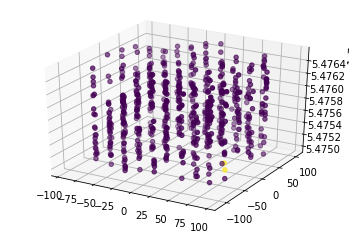

In [168]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['pos_x'], df['pos_y'], df['time'], marker='o', c=df['label'])

In [152]:
timeslice_10 = data[data['timeslice'].isin(timeslice_10_ids)]
timeslice_10

,pos_x,pos_y,pos_z,time,label,event_id,timeslice
4825023,-26.440,86.519,160.359,10530002.0,0,NaN,702
4825024,-65.315,-59.674,112.611,10530007.0,0,NaN,702
4825025,-7.025,-58.113,94.511,10530007.0,0,NaN,702
4825026,79.424,-6.083,140.059,10530009.0,0,NaN,702
4825027,-18.034,-4.309,83.611,10530015.0,0,NaN,702
...,...,...,...,...,...,...,...
44372052,69.262,11.967,169.111,96974995.0,0,NaN,6464
44372053,-46.326,-58.810,196.389,96974996.0,0,NaN,6464
44372054,58.844,66.171,65.459,96974997.0,0,NaN,6464
44372055,22.542,-113.896,178.231,96974997.0,0,NaN,6464


Text(0.5, 0, 'pos_x')

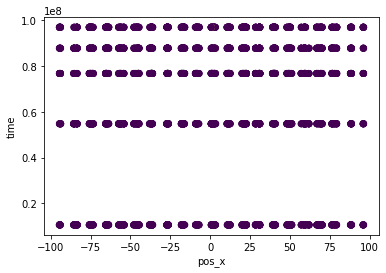

In [153]:
df = timeslice_10.sample(frac=0.1)
plt.scatter(df['pos_x'], df['time'], c=df['label'])
plt.ylabel('time')
plt.xlabel('pos_x')
# plt.savefig('../assets/dist-timeslice-largest-posx-time.png', dpi=200)

Difficult to see anything in a 2D plot, 3D might be better for these timeslices.